Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term

Normalized Time Values:
      time_normalized
0            0.000000
1            0.000347
2            0.000695
3            0.001042
4            0.001389
...               ...
2875         0.998611
2876         0.998958
2877         0.999305
2878         0.999653
2879         1.000000

[2880 rows x 1 columns]
Compiling model...
Building feed-forward neural network...
'build' took 0.016667 s

'compile' took 0.231753 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.63e-02, 9.50e-04, 3.62e-03, 1.00e+00, 6.78e-07, 0.00e+00, 5.34e-01]    [2.79e-02, 5.58e-07, 3.83e-06, 1.00e+00, 6.78e-07, 0.00e+00, 5.34e-01]    []  


I0000 00:00:1736369987.732286  225916 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


1         [1.52e-02, 9.80e-04, 3.62e-03, 9.98e-01, 4.65e-07, 5.65e-10, 5.31e-01]    [2.58e-02, 5.72e-07, 3.83e-06, 9.98e-01, 4.65e-07, 5.65e-10, 5.31e-01]    []  

Best model at step 1:
  train loss: 1.55e+00
  test loss: 1.56e+00
  test metric: []

'train' took 0.314213 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
1         [1.52e-02, 9.80e-04, 3.62e-03, 9.98e-01, 4.65e-07, 5.65e-10, 5.31e-01]    [2.58e-02, 5.72e-07, 3.83e-06, 9.98e-01, 4.65e-07, 5.65e-10, 5.31e-01]    []  
1000      [4.88e-05, 7.88e-05, 1.53e-05, 2.39e-04, 1.31e-06, 2.15e-08, 1.07e-02]    [7.02e-05, 2.55e-08, 1.84e-07, 2.39e-04, 1.31e-06, 2.15e-08, 1.07e-02]    []  
2000      [1.08e-05, 3.56e-05, 9.55e-06, 8.52e-08, 1.22e-07, 6.46e-09, 1.06e-02]    [1.93e-05, 6.47e-08, 1.74e-07, 8.52e-08, 1.22e-07, 6.46e-09, 1.06e-02]    []  
3000      [3.45e-06, 1.94e-05, 4.19e-06, 1.07e-

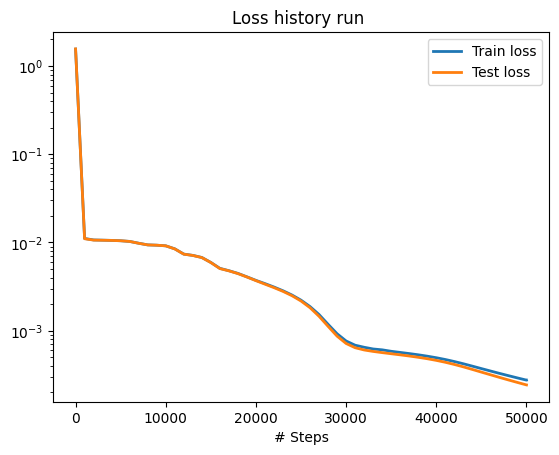

In [1]:
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from deepxde.backend import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pandas as pd
import deepxde as dde # version 0.11 or higher
#from generate_plot import plot_1D  # should be changed for the new one
import utils_inverse_Tom


def calculate_rmse(true_values, predicted_values):
    """Calculate Root Mean Square Error (RMSE)."""
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

def calculate_mae(true_values, predicted_values):
    """Calculate Mean Absolute Error (MAE)."""
    return np.mean(np.abs(true_values - predicted_values))

#% matplotlib inline

## Network Parameters
# Modified to match new requirements
input_size = 1  # network input size (time as 1D but input vector of size 5)
num_hidden_layers = 3  # number of hidden layers for NN
hidden_layer_size = 30  # size of each hidden layer
output_size = 3  # network output size (glucose)

## Training Parameters
num_domain = 3000  # number of training points within the domain
num_test = 1000  # number of testing points within the domain
num_initial = 1  # number of points to test the initial conditions
MAX_MODEL_INIT = 16  # maximum number of times allowed to initialize the model
MAX_LOSS = 4  # upper limit to the initialized loss
epochs = 50000  # number of epochs for training
lr = 0.00005  # learning rate
noise = 0.5  # noise factor
test_size = 0.1  # percentage of testing data


dim = 1  # Ensure dimension is set to
noise_introduced = False
inverse_activated = False # Switch on when trying to solve inverse problem


## Get Glucose Model Class
glucosemodel = utils_inverse_Tom.GlucoseModel(2)

## Parameters to inverse (if needed)
params = glucosemodel.set_parameters(2)

M = glucosemodel.M  # patient mass (kg)
ksi = glucosemodel.ksi  # Insulin sensitivity (mg glucose/U/min)
kl = glucosemodel.kl
kb = 128 / M

Ieq = (kl - kb) / ksi

## Load Data: Need to incorporate reading of a csv file
#data_t, data_g = pd.read_csv("/content/Pat2.csv", skiprows=1)  # extract the glucose data at least to start with, if more than only glucose is used then you have to arrange into an array and select the right column

df = pd.read_csv("Pat2.csv")

# Assign columns to data_t and data_g as matrices (DataFrames)
data_t = df.iloc[0:2880, [0]].values  # Column 1 = time points
data_g = df.iloc[0:2880, [2]].values  # Column 3 = glucose

# Normalize the glucose adn time data
max_glucose_value = data_g.max()  # The first value of the third column
data_g_normalised = data_g / max_glucose_value # New normaised data_g

max_time_value = data_t.max()  # The maximum value of the time points
data_t_normalised = data_t / max_time_value

data_t_normalised_df = pd.DataFrame(data_t_normalised, columns=["time_normalized"])
print("\nNormalized Time Values:")
print(data_t_normalised_df)

#For the moment the training set is too small because I wanted to guarantee that t0 would be in t_train, have to rewrite

first_t = data_t_normalised[0]
first_g = data_g_normalised[0]

# Remaining data
remaining_t = data_t_normalised[1:]
remaining_g = data_g_normalised[1:]

# Perform train_test_split on the remaining data
t_train, t_test, g_train, g_test = train_test_split(remaining_t, remaining_g, test_size=test_size)
train_set_size = np.size(t_train) + 1 # The 1 is added to account for the appending of the first_t and g that follows
# Add the first point to the training set
t_train = np.append([first_t], t_train)
t_train = np.reshape(t_train, (train_set_size, 1))

g_train = np.append([first_g], g_train)
g_train = np.reshape(g_train, (train_set_size, 1))

#Intial conditions
func_init = [data_g_normalised[0], Ieq, 0]

## Geometry and Time domains
geomtime = glucosemodel.geometry_time()

if noise_introduced:
    g_train = g_train + noise*np.random.randn(g_train.shape[0], g_train.shape[1])

def boundary(_, on_initial):
    return on_initial

## Define Initial Conditions: Keeping only the initial condition for patient 2 for simplicity
ic_g = dde.IC(geomtime, lambda x: func_init[0], boundary, component=0)
ic_i = dde.IC(geomtime, lambda x: func_init[1], boundary, component=1)
ic_d = dde.IC(geomtime, lambda x: func_init[2], boundary, component=2)

 ## Model observed data
observe_g = dde.PointSetBC(t_train, g_train, component=0)  # component says which equation of the ODE is used
input_data = [ic_g, ic_i, ic_d, observe_g]

## Define the Network
ode = glucosemodel.ode
net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")

ode_data = dde.data.PDE(geomtime, ode, input_data,
                            num_domain=num_domain,
                            #num_initial=num_initial,
                            anchors=t_train, #Should also see whether to add a 'solution' element to this function
                            num_test=num_test)
model = dde.Model(ode_data, net)
model.compile("adam", loss_weights=[1, 1, 1, 1, 1, 1, 1],lr=lr)

## Stabilize initialization process by capping the losses
losshistory, _ = model.train(epochs=1)
num_iterations = len(losshistory.loss_train)
initial_loss = max(losshistory.loss_train[num_iterations - 1])
num_init = 0

while initial_loss>MAX_LOSS or np.isnan(initial_loss).any() or np.isinf(initial_loss).any():  # added checking for inf values
    num_init += 1
    model = dde.Model(ode_data, net)
    model.compile("adam", lr=lr)
    #model.compile("adam", lr=lr, loss_weights=loss_weights)
    losshistory, _ = model.train(epochs=1)
    initial_loss = max(losshistory.loss_train[0])
    if num_init > MAX_MODEL_INIT:
        raise ValueError('Model initialization phase exceeded the allowed limit')

  ## Train Network
    # Inverse Function
if inverse_activated:
    param = glucosemodel.params_to
    variables_file = "run_ksi" + ".dat"
    variable = dde.callbacks.VariableValue(params, period=1000, filename=variables_file)
    losshistory, train_state = model.train(epochs=epochs, model_save_path= + 'run' + str(i), callbacks=[variable])
else:
    losshistory, train_state = model.train(epochs=epochs, model_save_path="/Users/harshith/documents/FYP", display_every=1000)

# Plot loss history
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

plt.figure()
plt.semilogy(losshistory.steps, loss_train, label="Train loss", linewidth=2)
plt.semilogy(losshistory.steps, loss_test, label="Test loss", linewidth=2)
plt.title("Loss history run ")
for i in range(len(losshistory.metrics_test[0])):
    plt.semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("# Steps")
plt.legend()
plt.savefig("Loss history run ")


## Compute rMSE for testing data & all (training + testing)
G_pred_test = model.predict(t_test)[:, 0:1]
G_pred_data = model.predict(data_t_normalised)[:, 0:1]
rmse_G_test = np.sqrt(np.square(G_pred_test - g_test).mean())
G_pred_train = model.predict(t_train)[:, 0:1]
rmse_G_train = np.sqrt(np.square(G_pred_train - g_train).mean())
G_test_err2 = np.square(G_pred_test - g_test)
G_train_err2 = np.square(G_pred_train - g_train )
G_all_err2 = np.concatenate((G_test_err2, G_train_err2))
rmse_G_all = np.sqrt( G_all_err2.mean() )

    # For Insulin
I_pred_data = model.predict(data_t_normalised)[:, 1:2]
I_pred_train = model.predict(t_train)[:, 1:2]

   # For Carbs
D_pred_data = model.predict(data_t_normalised)[:, 2:3]
D_pred_train = model.predict(t_train)[:, 2:3]

data_rmse = [rmse_G_test, rmse_G_train, rmse_G_all]


print('--------------------------')
print('G rMSE for test data:', rmse_G_test)
print('G rMSE for train data:', rmse_G_train)
print('G rMSE for all data:', rmse_G_all)
print('--------------------------')





# # First Plot: G_pred graph
# plt.figure(figsize=(10, 6))

# # Scatter plot for g_test against t_test
# plt.scatter(t_test * max_time_value, g_test * 220, label='Glucose Test Values (points)', s=20, color='blue')

# # Scatter plot for G_pred_test against t_test
# plt.scatter(t_test * max_time_value, G_pred_test * 220, label='Predicted Glucose Values (Test Sample) (crosses)', marker='x', s=20, color='red')

# # Line plot for G_pred_data against data_t
# plt.plot(data_t, G_pred_data * 220, label='Predicted Glucose Data (Full Sample Set)', linestyle='-', color='black')

# # Adding labels and legend
# plt.xlabel('Time (hours)')
# plt.ylabel('Glucose (mg/dL)')
# plt.title('Graph depicting Training and Predicted Test Glucose data')
# plt.legend()

# # Displaying the first plot
# plt.show()

# # Second Plot: I_pred graph
# plt.figure(figsize=(10, 6))

# # Line plot for I_pred_data against data_t
# plt.plot(data_t, I_pred_data, label='I_pred_data (line)', linestyle='-', color='black')

# # Scatter plot for I_pred_train against t_train
# plt.scatter(t_train * max_time_value, I_pred_train, label='I_pred_train (points)', marker='o', color='blue')

# # Adding labels and legend
# plt.xlabel('Time')
# plt.ylabel('I_pred values')
# plt.title('Graph of I_pred_data and I_pred_train')
# plt.legend()

# # Displaying the second plot
# plt.show()

# # Third Plot: D_pred graph
# plt.figure(figsize=(10, 6))

# # Line plot for D_pred_data against data_t
# plt.plot(data_t, D_pred_data, label='D_pred_data (line)', linestyle='-', color='black')

# # Scatter plot for D_pred_train against t_train
# plt.scatter(t_train * max_time_value, D_pred_train, label='D_pred_train (points)', marker='o', color='blue')

# # Adding labels and legend
# plt.xlabel('Time')
# plt.ylabel('D_pred values')
# plt.title('Graph of D_pred_data and D_pred_train')
# plt.legend()

# # Displaying the third plot
# plt.show()


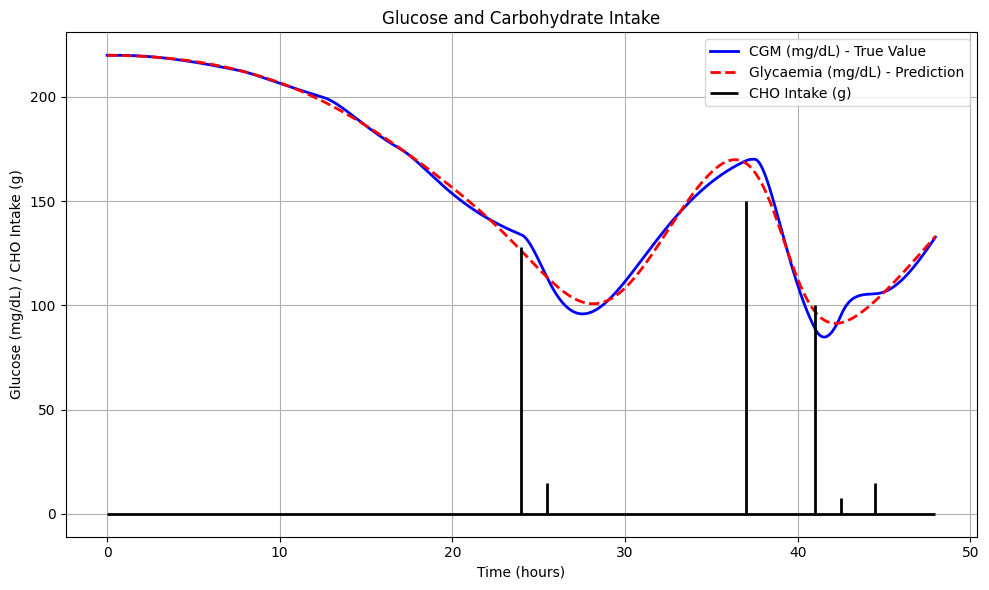

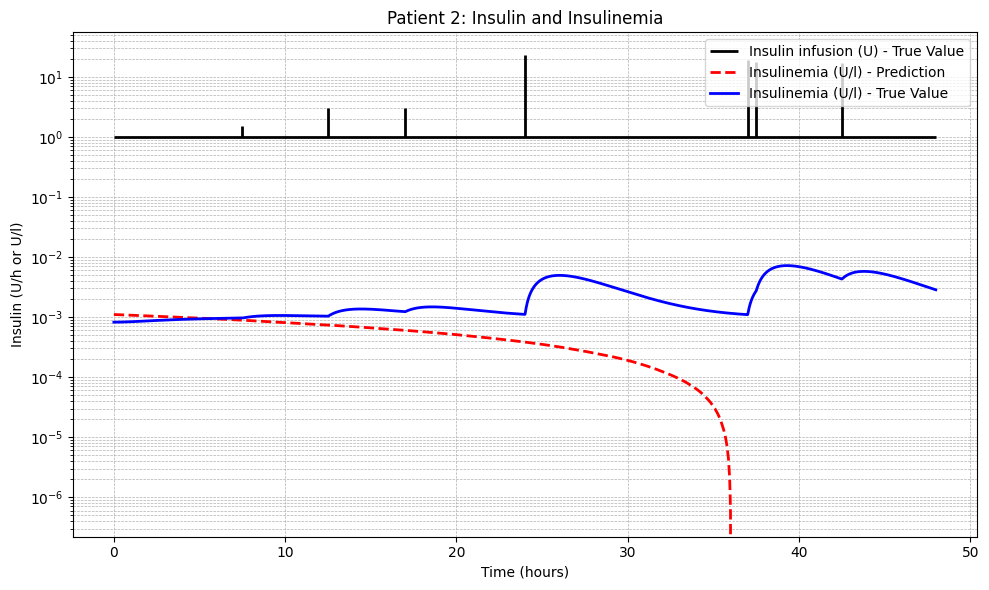

In [2]:
## Plots for the predicted data 

t = data_t.flatten()
# Hardcoded carbohydrate intake (mg) for Pat2
# Hardcoded carbohydrate intake (mg) for Pat2
rt = np.zeros_like(t, dtype=np.float64)  # Initialize as float
rt[t == 24 * 60] = 128
rt[t == 25.5 * 60] = 15
rt[t == 37 * 60] = 150
rt[t == 41 * 60] = 100
rt[t == 42.5 * 60] = 7.5
rt[t == 44.5 * 60] = 15
rt = rt * 1000  # Convert to milligrams if necessary

# Hardcoded insulin infusion rates (U) for Pat2
ut = np.ones_like(t, dtype=np.float64)  # Initialize as float
ut[t == 7.5 * 60] += 0.5
ut[t == 12.5 * 60] += 2
ut[t == 17 * 60] += 2
ut[t == 24 * 60] += 22
ut[t == 37 * 60] += 18
ut[t == 37.5 * 60] += 17
ut[t == 42.5 * 60] += 16
ut[t == 48 * 60] += 19


plt.figure(figsize=(10, 6))

# True Glucose (CGM Data)
plt.plot(
    data_t / 60,  # Convert time to hours
    data_g.flatten(),  # True glucose values
    linewidth=2,
    color="blue",
    label="CGM (mg/dL) - True Value",
)

# Predicted Glucose (Glycaemia)
plt.plot(
    data_t / 60,  # Convert time to hours
    G_pred_data.flatten() * 220,  # Predicted glucose values
    linewidth=2,
    linestyle="dashed",
    color="red",
    label="Glycaemia (mg/dL) - Prediction",
)

# Carbohydrate Intake
plt.vlines(
    data_t / 60,  # Convert time to hours
    ymin=0,
    ymax=rt / 1000,  # Carbohydrates in grams
    color="black",
    linewidth=2,
    label="CHO Intake (g)",
)

plt.hlines(
    y=0,  # Horizontal line at y=0
    xmin=0,  # Start at x=0
    xmax=data_t.max() / 60,  # Convert max time to hours
    color="black",
    linewidth=2,  # Adjust thickness as needed
)

# Labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("Glucose (mg/dL) / CHO Intake (g)")
plt.title("Glucose and Carbohydrate Intake")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# INSULIN
insulinemia = I_pred_data.flatten()
data_i = df.iloc[0:2880, [3]].values  # Column 5 = insulin

plt.figure(figsize=(10, 6))


# Insulin Infusion Rate with Vertical Lines
plt.vlines(
    data_t / 60,  # Convert time to hours
    ymin=1,  # Set to a small positive value for log scale
    ymax=ut,  # Scale insulin infusion rate for visibility
    color="black",
    linewidth=2,  # Adjust thickness as needed
    label="Insulin infusion (U) - True Value",
)

# Add a Horizontal Line at y=0 (Note: Logarithmic scale cannot have y=0 directly)
plt.hlines(
    y=1,  # Smallest visible value on the log scale
    xmin=0,  # Start at x=0
    xmax=data_t.max() / 60,  # End at the maximum time in hours
    color="black",
    linewidth=2,  # Adjust thickness if needed
)

# Predicted Insulin (Insulinemia)
plt.semilogy(
    data_t / 60,  # Convert time to hours
    insulinemia,  # Predicted insulin values
    linewidth=2,
    linestyle="dashed",
    color="red",
    label="Insulinemia (U/l) - Prediction",
)

plt.semilogy(
    data_t / 60,  # Convert time to hours
    data_i.flatten(),  # Predicted insulin values
    linewidth=2,
    color="blue",
    label="Insulinemia (U/l) - True Value",
)

# Labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("Insulin (U/h or U/l)")
plt.title("Patient 2: Insulin and Insulinemia")
plt.legend(loc="best")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



In [16]:
import numpy as np

def calculate_rmse(true_values, predicted_values):
    """Calculate Root Mean Square Error (RMSE)."""
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

def calculate_mae(true_values, predicted_values):
    """Calculate Mean Absolute Error (MAE)."""
    return np.mean(np.abs(true_values - predicted_values))


In [ ]:
# True glucose values
true_glucose = data_g.flatten()

# Predicted glucose values
predicted_glucose = G_pred_data.flatten() * 220

# Calculate RMSE and MAE for glucose
rmse_glucose = calculate_rmse(true_glucose, predicted_glucose)
mae_glucose = calculate_mae(true_glucose, predicted_glucose)

print(f"Glucose RMSE: {rmse_glucose:.5f} mg/dL")
print(f"Glucose MAE: {mae_glucose:.5f} mg/dL")


In [ ]:
# True insulin values
true_insulin = data_i.flatten()

# Predicted insulin values
predicted_insulin = insulinemia

# Calculate RMSE and MAE for insulin
rmse_insulin = calculate_rmse(true_insulin, predicted_insulin)
mae_insulin = calculate_mae(true_insulin, predicted_insulin)

print(f"Insulin RMSE: {rmse_insulin:.5f} U/l")
print(f"Insulin MAE: {mae_insulin:.5f} U/l")
